In [43]:
%reload_ext autoreload
import sys
sys.path.append("../utils/")

# general imports
import matplotlib.pyplot as plt
%matplotlib inline

# AWS imports: Import Braket SDK modules

from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np

import functools
import time

from quil_utils import *
from pyquil.quil import Pragma, Program
from pyquil.api import get_qc,QVM
from pyquil.gates import *
from quil_utils import Compiled_Circuit,Quil_to_Braket_Transpiler,Braket_to_Quil_Transpiler
from utils import DeviceUtils,DeviceScanner,BraketTaskScanner,Plotter
from IonQCompiler import IonQCompiler

import json
import pandas as pd
import seaborn as sns

In [44]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [45]:
@circuit.subroutine(register=True)
def H_line (n_qubits,line_length,device_name):
    """
    Creates a circuit with n_qubits, each with line_length hadamards applied
    
    Parameters:
    ----------------
    n_qubits : int #of qubits
    line_length : int # of Hadamards to apply to each qubit
    device_name : str #name of the QPU it is going to run on
    """
    base_circ = Circuit()
    for _ in range(line_length):
        base_circ.h(range(n_qubits))
        
    if device_name =='LocalSimulator':
        return base_circ

    elif device_name == 'Rigetti':
        qc = get_qc(name='Aspen-M-2',as_qvm=True)
        #first we compile Hadamard gate, then we repeat it in order to have it executed N times, first we transpile it in quil, then compile it, then retranspile in braket
        H_gate = Circuit().h(range(n_qubits))
        transpiled_H_gate = Braket_to_Quil_Transpiler(H_gate)
        compiled_H = transpiled_H_gate.verbatim_circ(qc)
        
        
        H_line_circ = Circuit()
        for _ in range(line_length):
            H_line_circ.add_circuit(compiled_H)
            
    elif device_name == 'IonQ':
        c = IonQCompiler()
        H_gate = Circuit().h(range(n_qubits))
        compiled_H = c.compile(H_gate)
        H_line_circ = Circuit()
        for _ in range(line_length):
            H_line_circ.add_circuit(compiled_H)
        
    return H_line_circ

In [46]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
# rigetti = LocalSimulator()
#ion_q = LocalSimulator()

#############################
Device name:  Aspen-M-2
Device type:  AwsDeviceType.QPU
Device arn:  arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2
Device provider: Rigetti
Device status: ONLINE
Device availability:  False
Device region:  us-west-1
Supported gates:  ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z', 'start_verbatim_box', 'end_verbatim_box']


['rx', 'rz', 'cz', 'cphaseshift', 'xy']

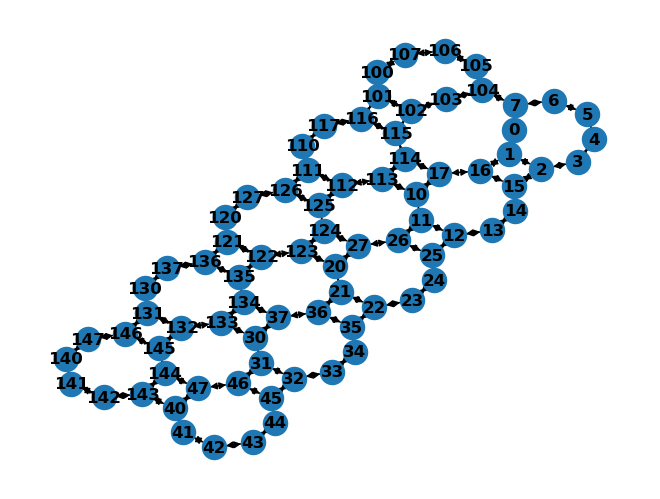

In [5]:
DeviceScanner(device=rigetti).list_properties()
DeviceScanner(device=rigetti).get_native_gates()

#############################
Device name:  IonQ Device
Device type:  AwsDeviceType.QPU
Device arn:  arn:aws:braket:::device/qpu/ionq/ionQdevice
Device provider: IonQ
Device status: ONLINE
Device availability:  True
Device region:  
Supported gates:  ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap']


['GPI', 'GPI2', 'MS']

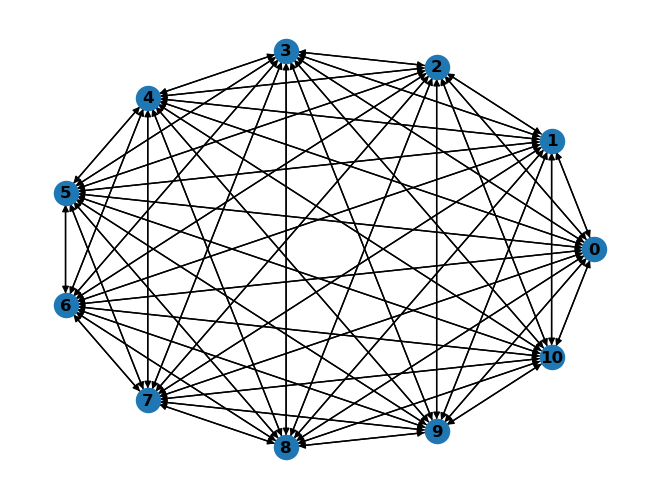

In [6]:
DeviceScanner(device=ion_q).list_properties()
DeviceScanner(device=ion_q).get_native_gates()

## Line_Hadamard
We apply a set of hadamards to 10 qubits, trying to benchmark them

In [101]:
shots = 100
#set_n_qubits = range(3,10)
n_qubits = 11
set_line_length = [10,20,30,50,100]
print(set_line_length)

[10, 20, 30, 50, 100]


First Rigetti

In [49]:
id_dict_rigetti = {}
rigetti_tasks = []

for line_length in set_line_length:
    id_dict_rigetti[str(line_length)] = {}
    
    circ = Circuit().H_line(n_qubits,line_length,'Rigetti')
    circ = Circuit().add_verbatim_box(circ)
   
    rigetti_task = rigetti.run(circ,shots=shots)
    rigetti_tasks.append(rigetti_task)
    
    id_dict_rigetti[str(line_length)] = {'rigetti' : {'id' : rigetti_task.id}}

And then ion_q

In [52]:
id_dict_ion_q = {}
ionq_tasks = []

for line_length in set_line_length:
    id_dict_ion_q[str(line_length)] = {}
    
    
    circ = Circuit().H_line(n_qubits,line_length,'IonQ')
    circ = Circuit().add_verbatim_box(circ)
   
    ionq_task = ion_q.run(circ,shots=shots)
    ionq_tasks.append(ionq_task)
    
    id_dict_ion_q[str(line_length)] = {'ionq' : {'id' : ionq_task.id}}

In [53]:
with open('H_line_rigetti.json','w') as f:
    json.dump(id_dict_rigetti,f,indent=3)
with open('H_line_ion_q.json','w') as f:
    json.dump(id_dict_ion_q,f,indent=3)


In [54]:
rigetti_ids = [task.id for task in rigetti_tasks]
ionq_ids = [task.id for task in ionq_tasks]


In [111]:
ionq_ids

['arn:aws:braket:us-east-1:058017682654:quantum-task/f0244b82-9c92-4d6b-a41a-bfe82c6335ad',
 'arn:aws:braket:us-east-1:058017682654:quantum-task/985f9134-4fca-41ba-9a3f-067378ab4194',
 'arn:aws:braket:us-east-1:058017682654:quantum-task/32be2612-4b49-4d07-84e0-65323b04a25b',
 'arn:aws:braket:us-east-1:058017682654:quantum-task/7a86240d-005d-4cf7-9f18-9e324f25a216',
 'arn:aws:braket:us-east-1:058017682654:quantum-task/1e1289b2-35c6-4ffc-b789-d4bbed0840e6']

In [55]:
rigetti_task_scanners = [BraketTaskScanner(qtask=task) for task in rigetti_tasks]
ion_q_task_scanners = [BraketTaskScanner(qtask=task) for task in ionq_tasks]

In [110]:
ionq_tasks[0].result()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

In [82]:
status_rigetti = [task.get_status() for task in rigetti_task_scanners]
status_ionq = [task.get_status() for task in ion_q_task_scanners]
print(status_rigetti,status_ionq)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED'] ['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [85]:
results_rigetti = [qtask.get_results() for qtask in rigetti_task_scanners]

In [84]:
results_ion_q = [qtask.get_results()for qtask in ion_q_task_scanners]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

In [94]:
t = ion_q_task_scanners[0].get_task()

In [96]:
t.result()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for idx,results in enumerate(results_rigetti):
    if set_line_length[idx]%2:
        counts = results.measurement_counts
        ax.plot([int(x,2) for x in counts.keys()],
                [x for x in counts.values()],
                #color="orange",
                marker = 'o',
                ms=5,
                linestyle='',
                label=str(set_line_length[idx]))
ax.set_ylim(0,10)
ax.legend()

# RIGETTI

Consideriamo per ora solo le linee con n pari

In [103]:

H_line_measures = {}
for i,H_len in enumerate(set_line_length):
    if H_len %2:
        continue
    results = results_rigetti[i]
#     measure[str(H_len)] = {}
#     meas = measure[str(H_len)]
    H_line_measures[str(H_len)] = []
    measure = H_line_measures[str(H_len)]
    for qubit_number in range(n_qubits):
        #meas[str(qubit_number)] = {'0':0,'1':0}
        ones = results.measurements[:,qubit_number].sum()
        zeros = shots - ones

        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '0',
                'counts' : zeros})
        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '1','counts':ones})
#         meas[str(qubit_number)]['1'] = ones
#         meas[str(qubit_number)]['0'] = zeros



AxesSubplot(0.125,0.747241;0.775x0.132759)
AxesSubplot(0.125,0.587931;0.775x0.132759)
AxesSubplot(0.125,0.428621;0.775x0.132759)
AxesSubplot(0.125,0.26931;0.775x0.132759)
AxesSubplot(0.125,0.11;0.775x0.132759)


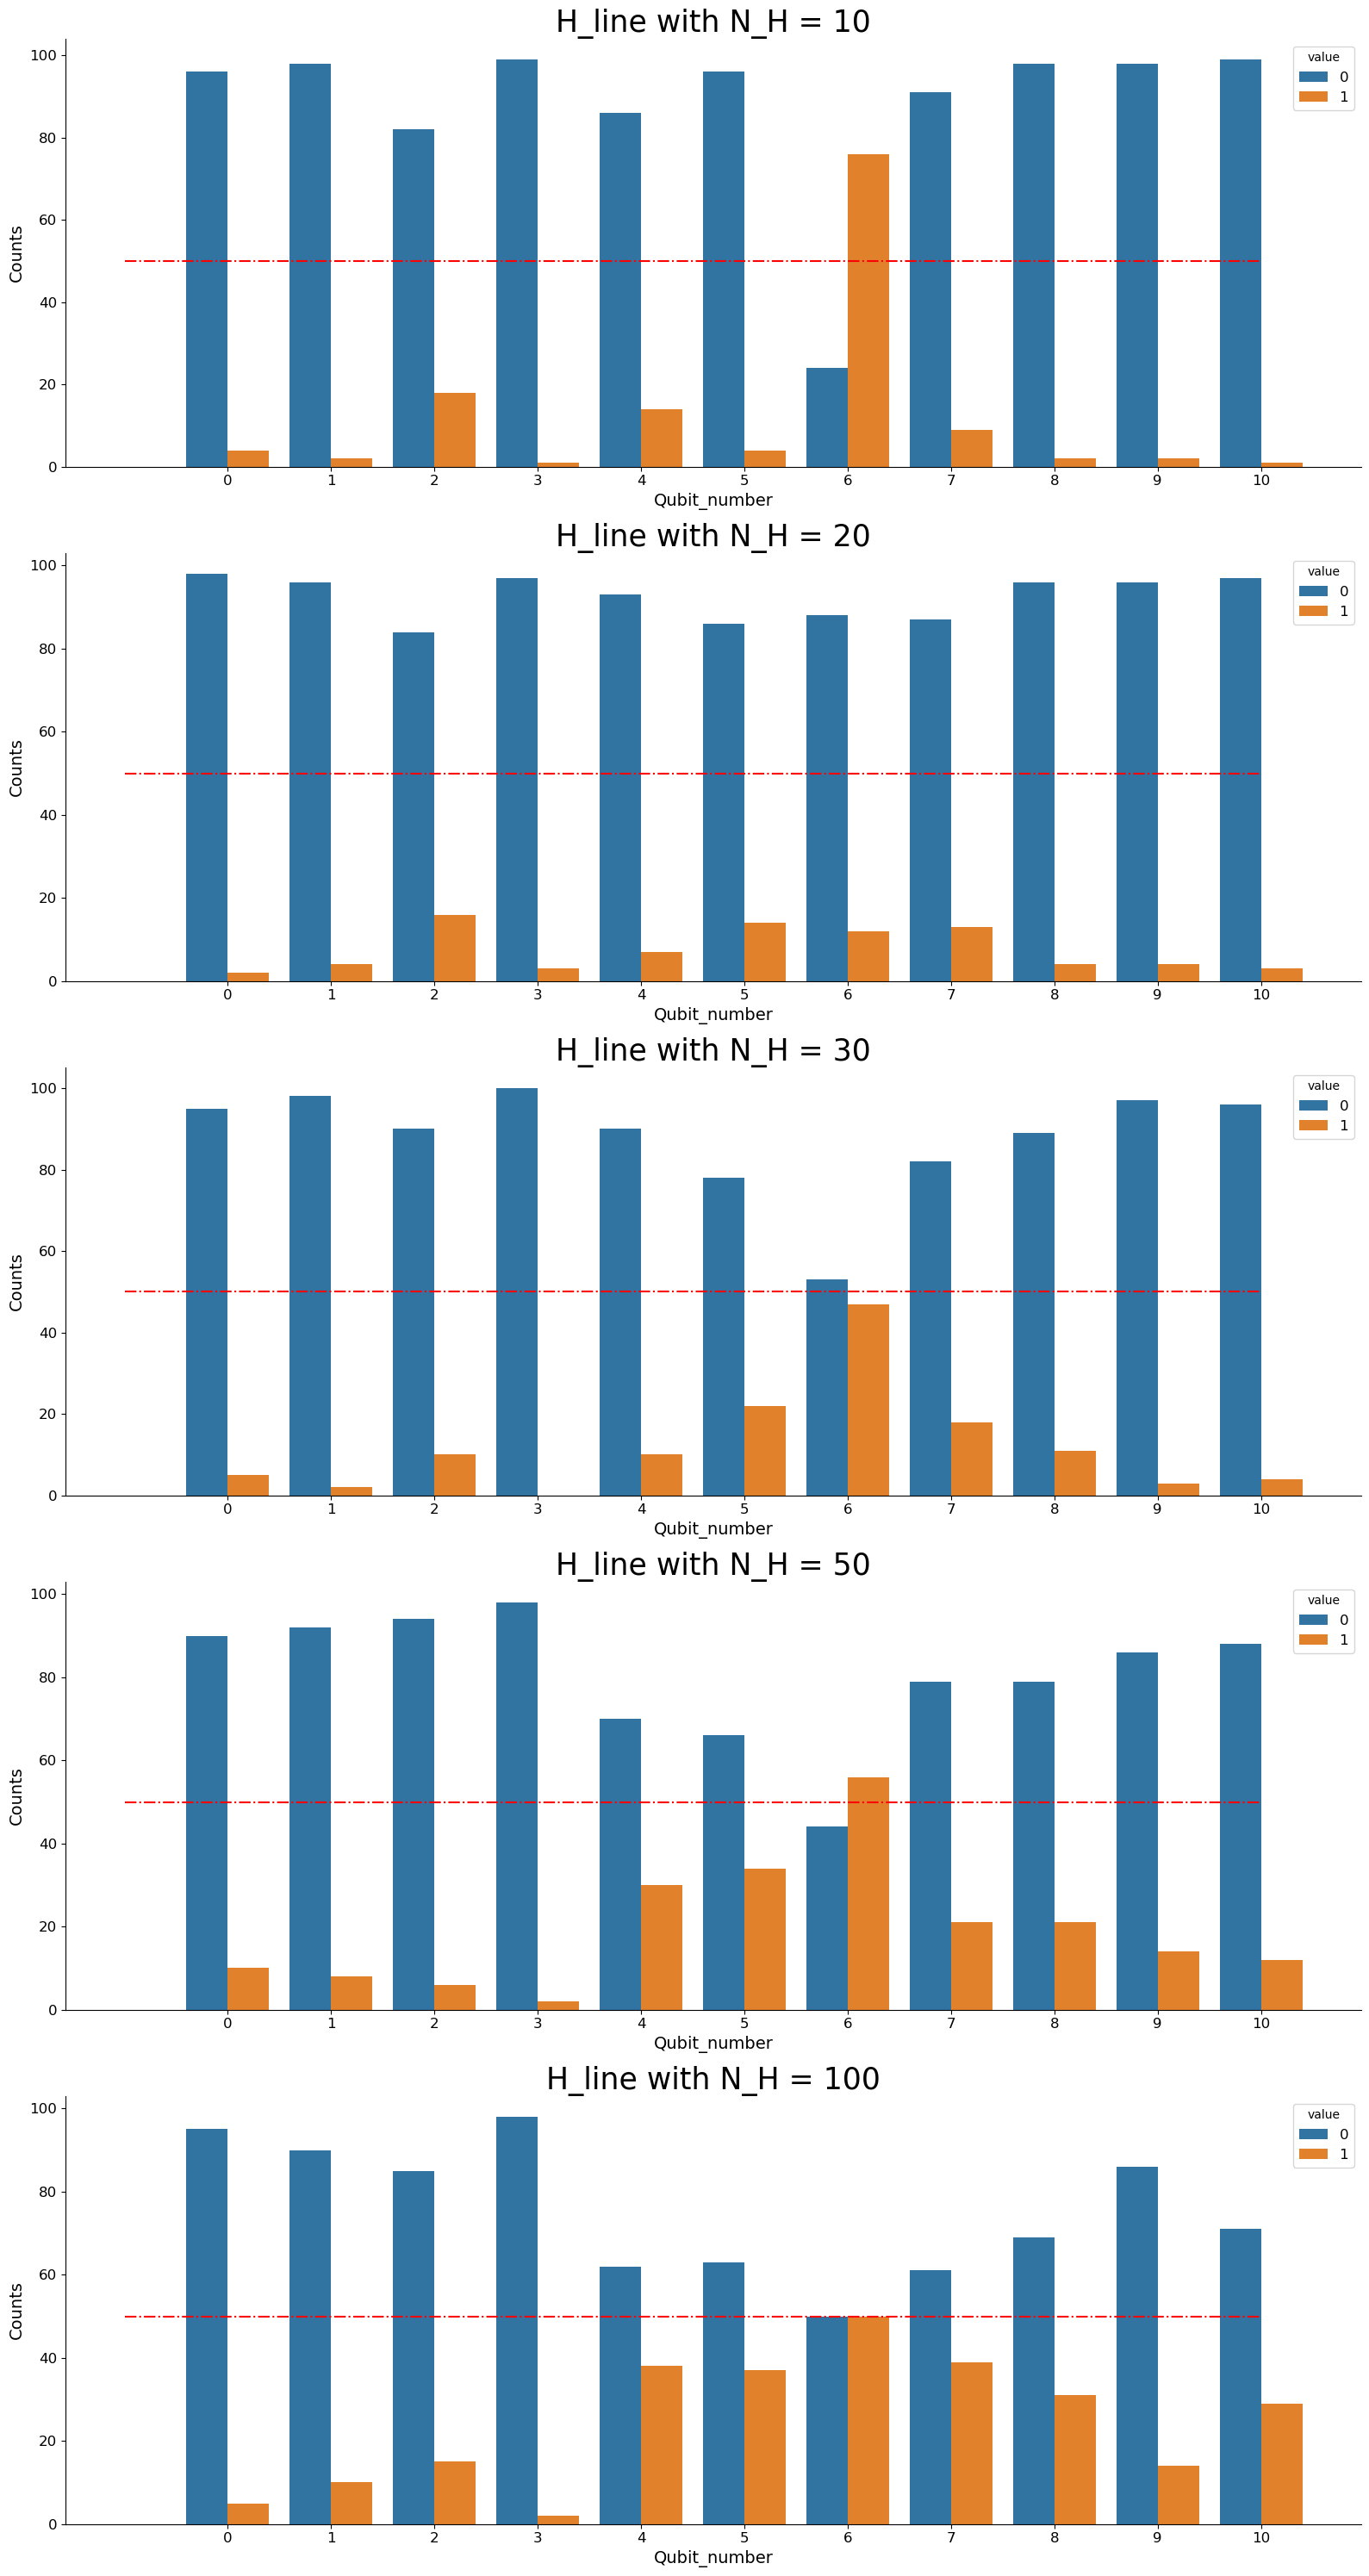

In [104]:
fig, axx = plt.subplots(5, 1, figsize=(16, 30),tight_layout=True,)
axx = axx.reshape(-1)
i=0
for key in H_line_measures:
    measure = H_line_measures[key]
    df = pd.DataFrame(measure)
    #print(df)
    ax = axx[i]
    i+=1
    print(ax)
    sns.barplot(x="qubit_n", y="counts",hue="value", data=df,ax=ax)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Qubit_number")
    ax.set_title(f"H_line with N_H = {key}",size=25)
    ax.hlines(50,-1,10,linestyles='-.',color='red')

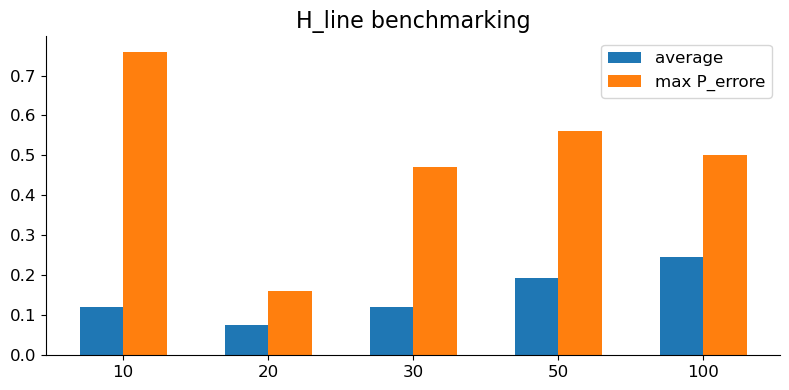

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(8,4),tight_layout=True,)
p_err = []
max_err = []
data_dict =[]
for key in H_line_measures:
    measure = H_line_measures[key]
    df = pd.DataFrame(measure)
    #print(df)
    p_err.append((df.counts[df.value=='1']/shots).mean())
    max_err.append(df.counts[df.value=='1'].max()/shots)

    
bar_width = .3
x = np.arange(len(H_line_measures))
b1 = ax.bar(x, p_err,
            width=bar_width,
           label = 'average')

b1 = ax.bar(x+bar_width, max_err,
            width=bar_width,
           label = 'max P_errore')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(H_line_measures.keys())
ax.set_title('H_line benchmarking')
ax.legend()

In [ ]:
compiled_circuits = [task.get_compiled_circuit() for task in rigetti_task_scanners]
circ = compiled_circuits[0]
circ

In [ ]:
N_gates = [len([line for line in circ.splitlines() if 'MEASURE' not in line])-3 for circ in compiled_circuits]
N_gates_per_qubit = N_gates
print(N_gates,N_gates_per_qubit)

# IonQ

In [ ]:

H_line_measures = {}
for i,H_len in enumerate(set_line_length):
    if H_len %2:
        continue
    results = results_ion_q[i]
#     measure[str(H_len)] = {}
#     meas = measure[str(H_len)]
    H_line_measures[str(H_len)] = []
    measure = H_line_measures[str(H_len)]
    for qubit_number in range(n_qubits):
        #meas[str(qubit_number)] = {'0':0,'1':0}
        ones = results.measurements[:,qubit_number].sum()
        zeros = shots - ones

        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '0',
                'counts' : zeros})
        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '1','counts':ones})
#         meas[str(qubit_number)]['1'] = ones
#         meas[str(qubit_number)]['0'] = zeros



In [ ]:
fig, axx = plt.subplots(len(H_line_measures), 1, figsize=(16, 30),tight_layout=True,)
axx = axx.reshape(-1)
i=0
for key in H_line_measures:
    measure = H_line_measures[key]
    df = pd.DataFrame(measure)
    #print(df)
    ax = axx[i]
    i+=1
    print(ax)
    sns.barplot(x="qubit_n", y="counts",hue="value", data=df,ax=ax)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Qubit_number")
    ax.set_title(f"H_line with N_H = {key}",size=25)
    ax.hlines(50,-1,10,linestyles='-.',color='red')

Plotting average fail probability and highest

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4),tight_layout=True,)
p_err = []
max_err = []
data_dict =[]
for key in H_line_measures:
    measure = H_line_measures[key]
    df = pd.DataFrame(measure)
    #print(df)
    p_err.append((df.counts[df.value=='1']/shots).mean())
    max_err.append(df.counts[df.value=='1'].max()/shots)

    
bar_width = .3
x = np.arange(len(H_line_measures))
b1 = ax.bar(x, p_err,
            width=bar_width,
           label = 'P errore')

b1 = ax.bar(x+bar_width, max_err,
            width=bar_width,
           label = 'max P_errore')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(H_line_measures.keys())
ax.set_title('H_line benchmarking')
ax.legend()

# TEST VERBATIM

In [6]:
circ = Circuit().H_line(10,4,'Rigetti')
verb = Circuit().h(range(2)).add_verbatim_box(ide)
print(verb)
ide

NameError: name 'ide' is not defined

In [7]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
# rigetti = LocalSimulator()
# ion_q = LocalSimulator()

In [15]:
task = rigetti.run(verb,shots=100)

In [16]:
task.id

'arn:aws:braket:us-west-1:058017682654:quantum-task/e8448828-9a9d-4f97-85bb-21e84917286f'

In [65]:
scanner = BraketTaskScanner(task_arn='arn:aws:braket:us-west-1:058017682654:quantum-task/e8448828-9a9d-4f97-85bb-21e84917286f')

In [66]:
scanner.get_status()

'COMPLETED'

In [67]:
results_rigetti=[scanner.get_results()] 

In [73]:
n_qubits=10
set_line_length = [4]
H_line_measures = {}
for i,H_len in enumerate(set_line_length):
    if H_len %2:
        continue
    results = results_rigetti[i]
#     measure[str(H_len)] = {}
#     meas = measure[str(H_len)]
    H_line_measures[str(H_len)] = []
    measure = H_line_measures[str(H_len)]
    for qubit_number in range(n_qubits):
        #meas[str(qubit_number)] = {'0':0,'1':0}
        ones = results.measurements[:,qubit_number].sum()
        zeros = shots - ones

        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '0',
                'counts' : zeros})
        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '1','counts':ones})
#         meas[str(qubit_number)]['1'] = ones
#         meas[str(qubit_number)]['0'] = zeros



AxesSubplot(0.125,0.11;0.775x0.77)


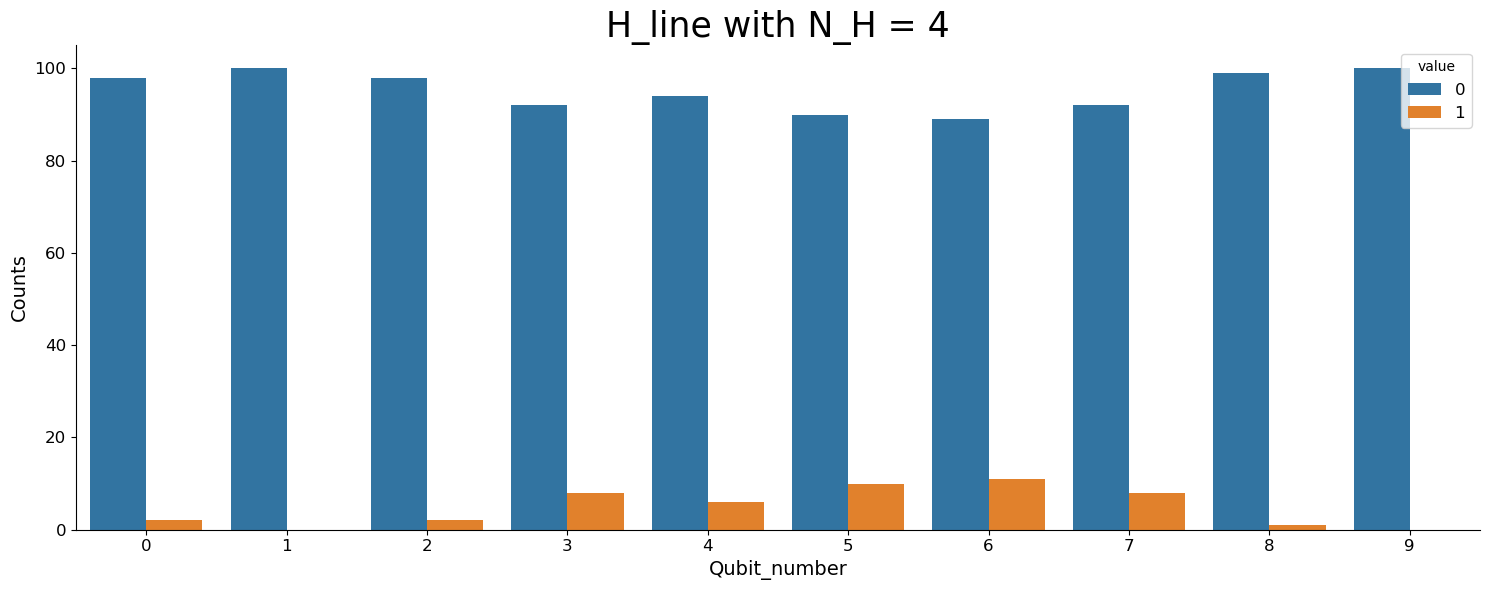

In [75]:
fig, axx = plt.subplots(len(H_line_measures), 1, figsize=(15, 6*len(H_line_measures)),tight_layout=True,)
# axx = axx.reshape(-1)
i=0
for key in H_line_measures:
    measure = H_line_measures[key]
    df = pd.DataFrame(measure)
    #print(df)
    ax = axx
#     i+=1
    print(ax)
    sns.barplot(x="qubit_n", y="counts",hue="value", data=df,ax=ax)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Qubit_number")
    ax.set_title(f"H_line with N_H = {key}",size=25)


In [51]:
print(scanner.get_compiled_circuit())

DECLARE ro BIT[10]
PRAGMA INITIAL_REWIRING "NAIVE"
RESET
RZ(pi/2) 7
RX(pi/2) 7
RZ(pi/2) 7
RZ(pi/2) 17
RX(pi/2) 17
RZ(pi/2) 17
RZ(pi/2) 23
RX(pi/2) 23
RZ(pi/2) 23
RZ(pi/2) 27
RX(pi/2) 27
RZ(pi/2) 27
RZ(pi/2) 43
RX(pi/2) 43
RZ(pi/2) 43
RZ(pi/2) 107
RX(pi/2) 107
RZ(pi/2) 107
RZ(pi/2) 111
RX(pi/2) 111
RZ(pi/2) 111
RZ(pi/2) 122
RX(pi/2) 122
RZ(pi/2) 122
RZ(pi/2) 136
RX(pi/2) 136
RZ(pi/2) 136
RZ(pi/2) 141
RX(pi/2) 141
RZ(pi/2) 141
RZ(pi/2) 7
RX(pi/2) 7
RZ(pi/2) 7
RZ(pi/2) 17
RX(pi/2) 17
RZ(pi/2) 17
RZ(pi/2) 23
RX(pi/2) 23
RZ(pi/2) 23
RZ(pi/2) 27
RX(pi/2) 27
RZ(pi/2) 27
RZ(pi/2) 43
RX(pi/2) 43
RZ(pi/2) 43
RZ(pi/2) 107
RX(pi/2) 107
RZ(pi/2) 107
RZ(pi/2) 111
RX(pi/2) 111
RZ(pi/2) 111
RZ(pi/2) 122
RX(pi/2) 122
RZ(pi/2) 122
RZ(pi/2) 136
RX(pi/2) 136
RZ(pi/2) 136
RZ(pi/2) 141
RX(pi/2) 141
RZ(pi/2) 141
RZ(pi/2) 7
RX(pi/2) 7
RZ(pi/2) 7
RZ(pi/2) 17
RX(pi/2) 17
RZ(pi/2) 17
RZ(pi/2) 23
RX(pi/2) 23
RZ(pi/2) 23
RZ(pi/2) 27
RX(pi/2) 27
RZ(pi/2) 27
RZ(pi/2) 43
RX(pi/2) 43
RZ(pi/2) 43
RZ(pi/2) 107
RX(pi/2) 

# IONQ

In [112]:
circ = Circuit().H_line(1,1,'IonQ')
circ = Circuit().add_verbatim_box(circ)

In [113]:
print(circ)

T  : |      0      |    1     |    2    |     3     |
                                                     
q0 : -StartVerbatim-GPi2(1.57)-GPi(0.00)-EndVerbatim-

T  : |      0      |    1     |    2    |     3     |


In [7]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
# rigetti = LocalSimulator()
# ion_q = LocalSimulator()

In [14]:
task = ion_q.run(circ,shots=100)

In [15]:
task.id

'arn:aws:braket:us-east-1:058017682654:quantum-task/baee28a1-34ce-4517-b1f7-5e54e13f3925'

In [16]:
scanner = BraketTaskScanner(task_arn='arn:aws:braket:us-east-1:058017682654:quantum-task/baee28a1-34ce-4517-b1f7-5e54e13f3925')

In [64]:
scanner.get_status()

'COMPLETED'

In [33]:
results_rigetti=[scanner.get_results()] 

In [52]:

H_line_measures = {}
set_line_length=[4]
for i,H_len in enumerate(set_line_length):
    if H_len %2:
        continue
    results = results_rigetti[i]
#     measure[str(H_len)] = {}
#     meas = measure[str(H_len)]
    H_line_measures[str(H_len)] = []
    measure = H_line_measures[str(H_len)]
    for qubit_number in range(n_qubits):
        #meas[str(qubit_number)] = {'0':0,'1':0}
        ones = results.measurements[:,qubit_number].sum()/shots
        zeros = 1 - ones/shots

        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '0',
                'counts' : zeros})
        measure.append({'H_len' : H_len,
                'qubit_n' : qubit_number,
               'value': '1','counts':ones})
#         meas[str(qubit_number)]['1'] = ones
#         meas[str(qubit_number)]['0'] = zeros



AxesSubplot(0.125,0.11;0.775x0.77)


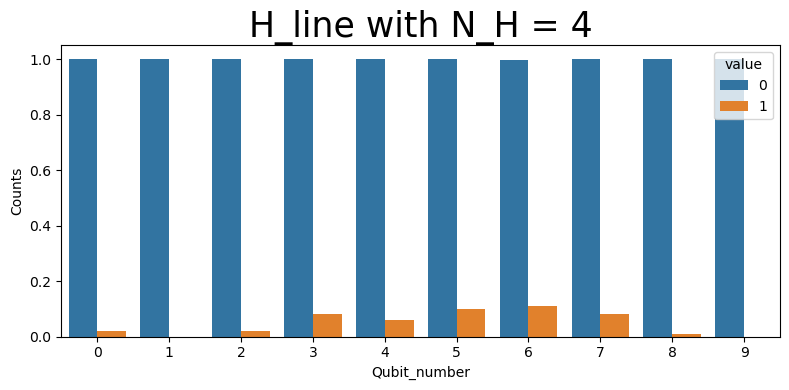

In [53]:
fig, axx = plt.subplots(len(H_line_measures), 1, figsize=(8,4*len(H_line_measures)),tight_layout=True,)
i=0
for key in H_line_measures:
    measure = H_line_measures[key]
    df = pd.DataFrame(measure)
    #print(df)
    ax = axx
    i+=1
    print(ax)
    sns.barplot(x="qubit_n", y="counts",hue="value", data=df,ax=ax)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Qubit_number")
    ax.set_title(f"H_line with N_H = {key}",size=25)
    #ax.hlines(50,-1,10,linestyles='-.',color='red')